In [553]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon May 22 14:13:15 2023

@author: souchaud
"""
import torch
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import sys
import shutil
import functions_analyze as lib
from scipy.signal import find_peaks

In [554]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device for torch operations:", device)

Device for torch operations: cpu


In [555]:
def force_field_inbox(coordinates_diff, distances, Req, R0, Frep, Fadh,
                      coeff_a = None, coeff_rep = None):
    """
    Calculate the force field within the focal box.

    Parameters
    ----------
    - coordinates_diff: Tensor representing the positions of particles in the focal box.

    Returns
    -------
    - force_field: Tensor representing the force field within the focal box.

    """  
    Rlim = 0.000001
    R = torch.norm(coordinates_diff, dim=2)
    # prevents the repulsion force from exploding when approaching its maximum value
    R = torch.where(R > Rlim*torch.ones(1, device=device),
                  R, Rlim*torch.ones(1, device=device)).to(device)
    
    ###########  R**2 adhesion force ###########
    # a = coeff_a
    # b = (Fadh-a*(R0**2-Req**2))/(R0-Req)
    # c = -Req*(a*Req+ (Fadh-a*(R0**2-Req**2))/(R0-Req))
    # force = torch.where(torch.logical_and(R < R0, R > Req),
    #                     -(a*R**2+b*R+c), torch.zeros_like(R)).to(device)
    
    ########### a*R**alpha + b ############
    alpha = coeff_a
    # force = torch.where(torch.logical_and(R < R0, R > Req),
    #                     -(Fadh/((R0**alpha)-(Req**alpha)))*((R**alpha)-(Req**alpha)), torch.zeros_like(R)).to(device)
    force = torch.where(torch.logical_and(R < R0, R > Req),
                        function_adh(R, Req, R0, Fadh, alpha, coeff_a=coeff_a), torch.zeros_like(R)).to(device)

    # The repulsion force is calculated wherever R<Req
    ########### Linear adhesion force ########### 
    # force = torch.where(torch.logical_and(R < R0, R > Req),
    #                     -((Fadh/(R0-Req))*R-Fadh*Req/(R0-Req)), torch.zeros_like(R)).to(device)

    ###########  Repulsion force linear ########## 
    # force = torch.where(R < Req,
    #                     - Frep*R*(1/Req-1/R), force).to(device)
    ########### Repulsion forces in 1/R ########### 
    force = torch.where(R <= Req,
                        - Frep*coeff_rep*(1/Req-1/R), force).to(device)

    force_field = torch.sum(force[:, :, None] *
                            torch.nn.functional.normalize(coordinates_diff, dim = 2), axis=1)

    return force_field


def function_adh(R, Req, R0, Fadh, alpha, coeff_a):
    # a = coeff_a
    # b = (Fadh-a*(R0**2-Req**2))/(R0-Req)
    # c = -Req*(a*Req+ (Fadh-a*(R0**2-Req**2))/(R0-Req))
    # return -(a*R**2+b*R+c)
    return -((Fadh/(R0-Req))*R-Fadh*Req/(R0-Req))

# def function_adh(R, Req, R0, Fadh, alpha,):
#     return -(Fadh/((R0-Req)**alpha))*((R-Req)**alpha)

def autovel(dX, n, tau, noise, dt, persistence):
    """
    Calcule la nouvelle direction des cellules basée sur leur déplacement,
    leur direction précédente, le bruit, le temps caractéristique tau, et la persistance.
    
    Paramètres
    ----------
    dX : Tensor
        Le déplacement des cellules durant le dernier intervalle de temps.
    n : Tensor
        La direction actuelle des cellules.
    tau : float
        Le temps caractéristique pour l'alignement de la polarisation dans
        la direction définie par la vitesse = dX/dt.
    noise : float
        L'intensité du bruit ajouté pour simuler des perturbations aléatoires
        dans la direction des cellules.
    dt : float
        L'intervalle de temps entre les mises à jour des positions.
    persistence : float
        Le facteur de persistance qui influence à quel point la direction actuelle
        est conservée. Valeur entre 0 (pas de persistance, direction entièrement aléatoire)
        et 1 (persistance complète, pas de changement de direction).

    Retour
    -------
    n : Tensor
        La nouvelle direction des cellules après mise à jour.
    """    
    # Compute the angle between the input vector and the x-axis
    theta = torch.atan2(dX[:, 1], dX[:, 0]).to(device)
    thetaf = theta.squeeze(0)
    if thetaf > 3.14:
        print ("coucou")
        print(thetaf)

    # Supposons que thetaf est un tenseur contenant une seule valeur
    if not (-np.pi <= thetaf <= np.pi):
        print(f"Valeur de thetaf hors de l'intervalle: {thetaf}")

    
    # Normalize the input vector
    dX_norm = torch.nn.functional.normalize(dX, dim=1) * 0.9999999
    if persistence == 1:
        persistence = 0.9999999
    # Compute the change in angle based on the orientation vector (n)
    dtheta = torch.arcsin((n[:, 0] * dX_norm[:, 1] - n[:, 1] * dX_norm[:, 0])) * dt / tau # * (1 - persistence))
    
    # Generate random noise for angle perturbation
    # rnd = noise * (2 * math.pi * (torch.rand(len(dX), 1, device=device) - 0.5)) * np.sqrt(dt) * (1 - persistence)
    rnd = noise * (2 * math.pi * (torch.rand(len(dX), 1, device=device) - 0.5)) * np.sqrt(dt) #* (1 - persistence)
    
    # Update the angle by adding the change in angle, random noise, and the previous angle
    theta += dtheta + rnd[:, 0]
    theta = theta.squeeze(0)
    # theta = theta % (2 * np.pi)  # Normalisez d'abord theta dans l'intervalle [0, 2*pi]
    # theta = (theta + np.pi) % (2 * np.pi) - np.pi
    theta = np.clip(theta, -np.pi, np.pi)


    # Calculate the weighted average of the new direction and the old direction
    new_dir_x = torch.cos(theta) #* (1 - persistence) + n[:, 0] * persistence
    new_dir_y = torch.sin(theta) #* (1 - persistence) + n[:, 1] * persistence
    
    # Normalize the new direction vector
    new_dir_norm = torch.sqrt(new_dir_x**2 + new_dir_y**2)
    n[:, 0].copy_(new_dir_x / new_dir_norm)
    n[:, 1].copy_(new_dir_y / new_dir_norm)
    
    # Retournez la nouvelle direction n
    return n, rnd, dtheta, thetaf


def plot_environment(cells, space_size,req, path_saving=None, iteration=None):
    fig, axis = plt.subplots(figsize=(6, 6))
    plt.xlim(0, space_size)
    plt.ylim(0, space_size)

    # Combine cells from both populations
    all_cells = population1.cells + population2.cells

    # Extract x and y coordinates
    x = [cell.position[0].item() for cell in all_cells]
    y = [cell.position[1].item() for cell in all_cells]

    # Create a list of colors corresponding to each cell
    colors = ['blue'] * len(population1.cells) + \
        ['red'] * len(population2.cells)

    # Plot all cells at once with the specified colors
    axis.scatter(x, y, s=3, color=colors,alpha=0.5, rasterized=True)

    # plt.title('Cell Movement')
    plt.xlabel('X position (micrometers)')
    plt.ylabel('Y position (micrometers)')
    # plt.axis('off')
    plt.axis('off')
    plt.savefig(f'{path_saving}image_{iteration}.png',
                bbox_inches='tight', dpi=400, pad_inches = 0)

    # plt.show()
    plt.close()
    # print(iteration)


def plot_function(pas, Req, R0, Frep, Fadh, a, coeff_rep):

    b = (Fadh-a*(R0**2-Req**2))/(R0-Req)
    c = -Req*(a*Req + (Fadh-a*(R0**2-Req**2))/(R0-Req))

    fig, axis = plt.subplots(figsize=(6, 6))
    plt.xlim(0, R0)
    plt.ylim(-Frep, Fadh)

    print("Req = ", Req)
    print("R0 = ", R0)
    print("Fadh = ", Fadh)
    print("Frep = ", Frep)

    axis.plot(np.arange(pas, Req, pas), [
              R*Frep*(1/Req-1/R) for R in np.arange(pas, Req, pas)], label='rep Mathieu')
    axis.plot(np.arange(pas, Req, pas), [
              Frep*coeff_rep*(1/Req-1/R) for R in np.arange(pas, Req, pas)], label='rep Alex')

    axis.plot(np.arange(Req, R0, pas), [
              (Fadh/(R0-Req))*(R-Req) for R in np.arange(Req, R0, pas)], label='adhline')
    axis.plot(np.arange(Req, R0, pas), [-function_adh(R, Req, R0, Fadh, alpha=0.5, coeff_a=30)
                                        for R in np.arange(Req, R0, pas)], alpha=0.5, label='adh_Alex')
    axis.plot(np.arange(Req, R0, pas), [(a*R**2+b*R+c)
              for R in np.arange(Req, R0, pas)], label="square")

    # (Fadh/(R0-Req))*R+Fadh*Req/(R0-Req)

    plt.xlabel('Distance')
    plt.ylabel('Force')
    plt.legend()
    plt.show()

In [556]:
np.cos(5*np.pi/2)

3.061616997868383e-16

In [557]:
class CellAgent:
    def __init__(self, position, velocity, velocity_magnitude, persistence, space_size):
        # We add the inital position to make some calc later.
        self.position_init = position.clone().to(device)
        self.position = position.clone().to(device)
        self.velocity = velocity.clone().to(device)
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.space_size = space_size
        self.direction = torch.nn.functional.normalize(velocity, p=2, dim=0)
        self.dtheta = 0
        self.random = 0
        self.theta = 0
    def theta(self):
        theta = self.thetaf # Obtenir la valeur actuelle de thetaf
        if theta < -np.pi:
            theta += 2 * np.pi  # Ajuster si en dessous de la limite inférieure
        elif theta > np.pi:
            theta -= 2 * np.pi  # Ajuster si au-dessus de la limite supérieure
        return theta  # Renvoyer la valeur ajustée ou d'origine

In [558]:
class Population:
    def __init__(self, num_cells, space_size, velocity_magnitude, persistence, min_distance):
        self.num_cells = num_cells
        self.space_size = space_size
        self.velocity_magnitude = velocity_magnitude
        self.persistence = persistence
        self.min_distance = min_distance
        self.cells = []
        self.initialize_cells()

    def initialize_cells(self):
        positions = torch.rand((self.num_cells, 2), device=device) * self.space_size
        directions = torch.nn.functional.normalize(torch.empty_like(positions).uniform_(-1, 1), dim=1)
        
        # Générez les vitesses initiales selon une distribution gaussienne
        ecart_type_vitesse = 0.9  # À ajuster selon vos besoins
        vitesses_gaussiennes = torch.normal(mean=self.velocity_magnitude, std=ecart_type_vitesse, size=(self.num_cells,))
        # Créer vitesses_gaussiennes avec la même forme que la sortie de torch.normal()
        vitesses_gaussiennes = torch.full((self.num_cells,), self.velocity_magnitude)
        # Appliquez les vitesses gaussiennes aux directions pour obtenir les vecteurs de vitesse
        velocities = directions * vitesses_gaussiennes[:, None]

        if self.min_distance != 0:
          # Create a grid with cell size equal to the minimum distance
          grid_size = int(np.ceil(self.space_size / self.min_distance))
          grid = [[[] for _ in range(grid_size)] for _ in range(grid_size)]

          valid_positions = []
          for i in range(self.num_cells):
              valid = True

              # Compute the cell's grid indices
              grid_x = int(positions[i, 0] / self.min_distance)
              grid_y = int(positions[i, 1] / self.min_distance)

              # Check neighboring cells in the grid
              for dx in [-1, 0, 1]:
                  for dy in [-1, 0, 1]:
                      nx = grid_x + dx
                      ny = grid_y + dy

                      # Check if the neighboring grid cell is valid
                      if 0 <= nx < grid_size and 0 <= ny < grid_size:
                          for cell_pos in grid[nx][ny]:
                              # Check the distance between the current cell and the neighboring cells
                              if torch.norm(positions[i] - cell_pos) < self.min_distance:
                                  valid = False
                                  break
                      if not valid:
                          break
                  if not valid:
                      break
              if valid:
                  # Add the cell position to the grid
                  grid[grid_x][grid_y].append(positions[i])
                  valid_positions.append(positions[i])
              else:
                  # Generate a new random position until a valid one is found
                  while not valid:
                      positions[i] = torch.rand((1, 2), device=device) * self.space_size

                      # Compute the updated cell's grid indices
                      grid_x = int(positions[i, 0] / self.min_distance)
                      grid_y = int(positions[i, 1] / self.min_distance)

                      # Check neighboring cells in the grid
                      valid = True
                      for dx in [-1, 0, 1]:
                          for dy in [-1, 0, 1]:
                              nx = grid_x + dx
                              ny = grid_y + dy

                              # Check if the neighboring grid cell is valid
                              if 0 <= nx < grid_size and 0 <= ny < grid_size:
                                  for cell_pos in grid[nx][ny]:
                                      # Check the distance between the current cell and the neighboring cells
                                      if torch.norm(positions[i] - cell_pos) < self.min_distance:
                                          valid = False
                                          break
                              if not valid:
                                  break
                          if not valid:
                              break

                  # Add the cell position to the grid
                  grid[grid_x][grid_y].append(positions[i])
                  valid_positions.append(positions[i])
        else :
          valid_positions = [positions[i] for i in range(len(positions))]

        # self.cells = [CellAgent(position, velocities[i], self.velocity_magnitude, self.persistence, self.space_size) for i, position in enumerate(valid_positions)]
        self.cells = [CellAgent(position, directions[i] * vitesses_gaussiennes[i], vitesses_gaussiennes[i], self.persistence, self.space_size) for i, position in enumerate(positions)]


In [559]:
class Surface:
    def get_friction(self, position):
        friction = torch.empty(1).uniform_(0, 0.2).to(device)
        return friction.item()

88 cells
Req =  1.1
R0 =  1.6
Fadh =  7
Frep =  40


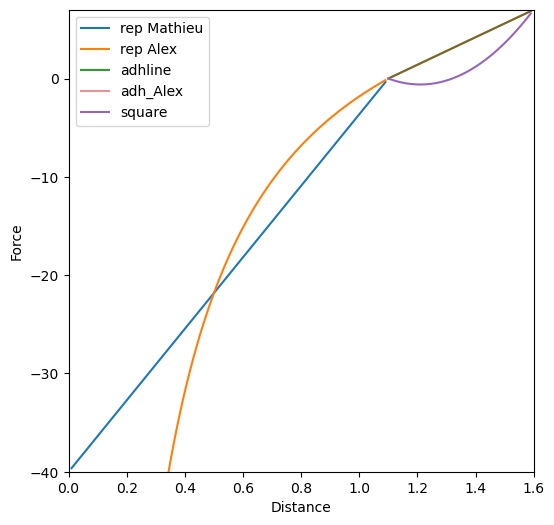

In [560]:
# In[Simulation parameters]
# Space parameters
SPACE_SIZE = 2048 #1308 # Micrometers

# time settings
TIME_SIMU = 2 # time simulation in minutes
DELTA_T = 0.01 # 15/60 # 0.01 # simulation interval in minutes
PLOT_INTERVAL = 100 # 25

# simulation parameters
MU = 0 #1  # mobility in min.kg-1
F_REP = 40  # repulsive strength
F_ADH = 7 # 3 #4 #attractive strength force kg.um.min-2
R_EQ = 1.1 # 11  # equilibrium radius in um
R_0 = 1.6 # 16  # interaction radius in um
MIN_DISTANCE_INIT = R_EQ

# factor simulation
NOISE = 5 #10 # noise intensity
FLUCTUATION_FACTOR = 0 #4
TAU = 5 # 5 # characteristic time for the polarization to align in the scattering direction defined by v=dr/dt = time
PERSISTENCE_POP1 = 0 #0.1
PERSISTENCE_POP2 = 0 #0.4

# Cells definition
PACKING_FRACTION = 0.00002
N_CELLS = int((PACKING_FRACTION*SPACE_SIZE**2)/
              (math.pi*((R_EQ/2)**2)))  # number of particles
# N = 2000
print(N_CELLS, "cells")
velocity_magnitude_pop1 = 5 #um/min
velocity_magnitude_pop2 = 5 # um/min

COEFF_CARRE = 50
COEFF_REP = 0.5
plot_function(pas=0.01, Req=R_EQ, R0=R_0, Frep=F_REP,
              Fadh=F_ADH, a=COEFF_CARRE, coeff_rep=COEFF_REP)

In [561]:
# In[Definition of the populations]
population1 = Population(num_cells=int(N_CELLS/2), space_size=SPACE_SIZE,\
                         velocity_magnitude=velocity_magnitude_pop1,\
                         persistence=PERSISTENCE_POP1,\
                         min_distance=MIN_DISTANCE_INIT)

population2 = Population(num_cells=int(N_CELLS/2), space_size=SPACE_SIZE,\
                         velocity_magnitude=velocity_magnitude_pop2,\
                         persistence=PERSISTENCE_POP2,\
                         min_distance=MIN_DISTANCE_INIT)

cells = population1.cells + population2.cells

surface = Surface()

In [562]:
# In[initialisation]
positions = torch.stack([cell.position_init for cell in cells])
V0 = torch.tensor([cell.velocity_magnitude for cell in cells], device = device).unsqueeze(1)
direction = torch.stack([cell.direction for cell in cells])
positions = torch.stack([cell.position for cell in cells])
PATH = f'/Users/souchaud/Desktop/simu/v1{velocity_magnitude_pop1}v2{velocity_magnitude_pop2}a{COEFF_CARRE}coefrep{COEFF_REP}fadh{F_ADH}frep{F_REP}/'
if not os.path.exists(PATH):
    os.mkdir(PATH)
else :
    print("WARNING : FOLDER DOES ALREADY EXIST!")
    sys.exit(0)
plot_environment(cells, space_size= SPACE_SIZE, req=R_EQ,
                 path_saving=PATH, iteration = 0)

In [563]:
# In[Simulation]
import pandas as pd
# Création du DataFrame vide
columns = ['frame', 'particle', 'x', 'y','dir_x', 'dir_y', 'theta', 'dtheta', 'rnd']
data_frame = pd.DataFrame(columns=columns)
time = 0
iteration = 1
MAX_DISTANCE = np.sqrt(2*(SPACE_SIZE/2)**2)

while time < TIME_SIMU :
    #Paiwise distance.
    coordinates_diff = ((positions[:, None, :] - positions[None, :, :]))
    coordinates_diff = torch.remainder(coordinates_diff-(SPACE_SIZE/2),SPACE_SIZE)-(SPACE_SIZE/2)
    distances = torch.stack([torch.norm(coordinates_diff[i], dim=1)
                             for i in range(0, len(coordinates_diff))])
    is_greater_than_max = torch.any(distances > MAX_DISTANCE)

    if is_greater_than_max:
      print("At least one distance is greater than the max distance.")

    # force_field calculation
    force_field = force_field_inbox(coordinates_diff, distances, Req=R_EQ,
                                    R0=R_0, Frep=F_REP, Fadh=F_ADH,
                                    coeff_a = COEFF_CARRE, coeff_rep = 0.5)
    
    # displacement computing
    fluctuations = (torch.rand(V0.shape, device=V0.device) - 0.5) * FLUCTUATION_FACTOR
    displacement = MU * force_field * DELTA_T +\
                   (V0 + fluctuations) * direction * DELTA_T
    
    # cells position evolution
    positions += displacement

    # border conditions
    positions = torch.remainder(positions, SPACE_SIZE)

    for cell, position, direct in zip(cells, positions, direction):
        cell.position = position.to(device)
        cell.direction = direct.to(device)
        # print(cell, position, direct)
    rnd_list = []
    dtheta_list = []
    for i, cell in enumerate(population1.cells):
       # Extraire le déplacement spécifique à cette cellule
        cell_displacement = displacement[i, :].unsqueeze(0)  # Ajoute une dimension pour conserver la forme [1, 2]
        # Appeler autovel et récupérer la nouvelle direction et l'angle
        new_direction, rnd, dtheta, thetaf = autovel(cell_displacement, cell.direction.unsqueeze(0), TAU, NOISE, DELTA_T, persistence=cell.persistence)
        # S'il y a besoin d'utiliser .squeeze(0) sur new_direction, assurez-vous de l'appliquer correctement
        cell.direction = new_direction.squeeze(0)  # Utiliser .squeeze(0) si new_direction a une dimension superflue
        cell.dtheta = dtheta.squeeze(0)
        cell.random = rnd.squeeze(0)
        cell.theta = theta.squeeze(0)
    # Faire de même pour la population 2
    for i, cell in enumerate(population2.cells):
        # Extraire le déplacement spécifique à cette cellule
        cell_displacement = displacement[i, :].unsqueeze(0)  # Ajoute une dimension pour conserver la forme [1, 2]
        # Appeler autovel et récupérer la nouvelle direction et l'angle
        new_direction, rnd, dtheta, theta = autovel(cell_displacement, cell.direction.unsqueeze(0), TAU, NOISE, DELTA_T, persistence=cell.persistence)      
        # S'il y a besoin d'utiliser .squeeze(0) sur new_direction, assurez-vous de l'appliquer correctement
        cell.direction = new_direction.squeeze(0)  # Utiliser .squeeze(0) si new_direction a une dimension superflue
        cell.dtheta = dtheta.squeeze(0)
        cell.random = rnd.squeeze(0)
        cell.theta = theta.squeeze(0)

  
    # plot the result
    marker_radius = 1.1
    marker_size = (np.pi) * marker_radius ** 2
    if iteration % PLOT_INTERVAL == 0:
      plot_environment(cells, path_saving = PATH, space_size = SPACE_SIZE, req=R_EQ, iteration = iteration)

    # À la fin de chaque itération de la boucle, enregistrez les coordonnées et les directions
    temp_data = []
    for i, cell in enumerate(cells):
        # Supposons que 'positions' et 'cell.direction' sont accessibles et contiennent les informations nécessaires
        position_x, position_y = positions[i][:2]  # Extrait les coordonnées x et y
        dir_x, dir_y = cell.direction[:2]  # Extrait les composantes x et y de la direction
        dtheta = cell.dtheta.item()  # Extrait la valeur de dtheta
        rnd = cell.random.item()  # Extrait la valeur de rnd
        thetaf = cell.theta.item()
        # Ajoutez ces informations à temp_data
        temp_data.append([time, i, position_x.item(), position_y.item(), dir_x.item(), dir_y.item(), thetaf,  dtheta, rnd])

    # Conversion de temp_data en DataFrame temporaire
    temp_df = pd.DataFrame(temp_data, columns=['frame', 'particle', 'x', 'y', 'dir_x', 'dir_y', 'theta', 'dtheta', 'rnd'])

    # Concaténez ce DataFrame temporaire avec le DataFrame principal
    data_frame = pd.concat([data_frame, temp_df], ignore_index=True)

    # Après avoir mis à jour toutes les cellules
    direction = torch.stack([cell.direction for cell in cells])
    # Mise à jour du temps
    time += DELTA_T
    # print(time)
    iteration += 1

/var/folders/sk/m9jkmr4n1k5dqc3wj_f53p4r0000gp/T/ipykernel_2334/3306250805.py:88: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_frame = pd.concat([data_frame, temp_df], ignore_index=True)


coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
tensor(3.1416)
coucou
ten

In [564]:
df

,frame,particle,x,y,dir_x,dir_y,theta,dtheta,rnd,dx,dy,distance,vitesse,dir_x_next,dir_y_next,angle_change
0,0,0,612.615234,951.144897,0.720812,-6.931303e-01,tensor(2.9499),0.000000e+00,1.422585,0.000000,0.000000,0.000000,0.000000,0.854628,-5.192402e-01,0.219861
1,0.01,0,612.651245,951.110229,0.854628,-5.192402e-01,tensor(-0.7815),1.192093e-10,0.219861,0.036011,-0.034668,0.049986,4.998641,0.796874,-6.041453e-01,-0.102731
2,0.02,0,612.693970,951.084290,0.796874,-6.041453e-01,tensor(-0.8190),1.192093e-10,-0.102731,0.042725,-0.025940,0.049983,4.998273,0.269391,-9.630310e-01,-0.649343
3,0.03,0,612.733826,951.054077,0.269391,-9.630310e-01,tensor(-0.5166),-5.960464e-11,-0.649343,0.039856,-0.030212,0.050013,5.001286,-0.246639,-9.691073e-01,-0.521971
4,0.04,0,612.747314,951.005920,-0.246639,-9.691073e-01,tensor(1.2148),-5.960464e-11,-0.521971,0.013489,-0.048157,0.050010,5.001018,0.653594,-7.568454e-01,0.961534
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17594,1.94,87,2021.504272,1035.594482,-0.057045,9.983716e-01,tensor(1.6279),-7.251917e-04,-1.150399,-0.050049,0.000000,0.050049,5.004883,-1.000000,1.224647e-16,1.513720
17595,1.95,87,2021.501465,1035.644409,-1.000000,1.224647e-16,tensor(3.7820),3.027436e-03,0.637355,-0.002808,0.049927,0.050006,5.000564,-1.000000,1.224647e-16,0.000000
17596,1.96,87,2021.451416,1035.644409,-1.000000,1.224647e-16,tensor(3.8508),-1.719816e-04,0.795388,-0.050049,0.000000,0.050049,5.004883,-1.000000,1.224647e-16,0.000000
17597,1.97,87,2021.401367,1035.644409,-1.000000,1.224647e-16,tensor(4.2531),0.000000e+00,1.111493,-0.050049,0.000000,0.050049,5.004883,-0.967483,2.529368e-01,-0.255715


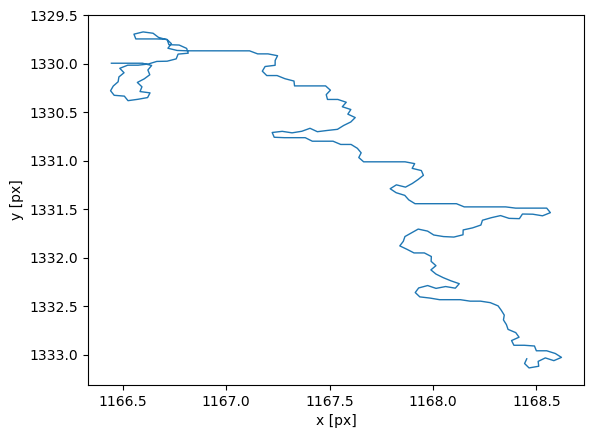

In [565]:
import trackpy as tp
tp.plot_traj(data_frame[data_frame['particle']==1])
data_frame.groupby('particle')

In [566]:
def adjust_positions_xy(group):
    SPACE_SIZE_X = SPACE_SIZE  # La taille de l'espace toroïdal en x
    SPACE_SIZE_Y = SPACE_SIZE  # La taille de l'espace toroïdal en y, ajustez selon votre espace
    # Calculer les différences pour obtenir 'dx' et 'dy'
    group['dx'] = group['x'].diff().fillna(0)
    group['dy'] = group['y'].diff().fillna(0)
    
    # Initialiser de nouvelles colonnes pour les positions ajustées
    group['adjusted_x'] = group['x'].copy()
    group['adjusted_y'] = group['y'].copy()
    
    # Ajuster les positions en x
    for i in range(1, len(group)):
        if group.iloc[i]['dx'] > SPACE_SIZE_X / 2:
            group['adjusted_x'].iloc[i:] -= SPACE_SIZE_X
        elif group.iloc[i]['dx'] < -SPACE_SIZE_X / 2:
            group['adjusted_x'].iloc[i:] += SPACE_SIZE_X
            
    # Ajuster les positions en y
    for i in range(1, len(group)):
        if group.iloc[i]['dy'] > SPACE_SIZE_Y / 2:
            group['adjusted_y'].iloc[i:] -= SPACE_SIZE_Y
        elif group.iloc[i]['dy'] < -SPACE_SIZE_Y / 2:
            group['adjusted_y'].iloc[i:] += SPACE_SIZE_Y
            
    # Calculer dx et dy ajustés après correction
    group['adjusted_dx'] = group['adjusted_x'].diff().fillna(0)
    group['adjusted_dy'] = group['adjusted_y'].diff().fillna(0)
    
    return group

# Assurez-vous que votre DataFrame df_final contient une colonne 'y' pour chaque position y
# Par exemple, ajouter: df_final['y'] = [valeur_y1, valeur_y2, ...] pour chaque particule

# Appliquer la fonction à chaque groupe de particules et concaténer les résultats
df_adjusted = data_frame.groupby('particle').apply(adjust_positions_xy).reset_index(drop=True)

df_adjusted['x'] = df_adjusted['adjusted_x']
df_adjusted['y'] = df_adjusted['adjusted_y']


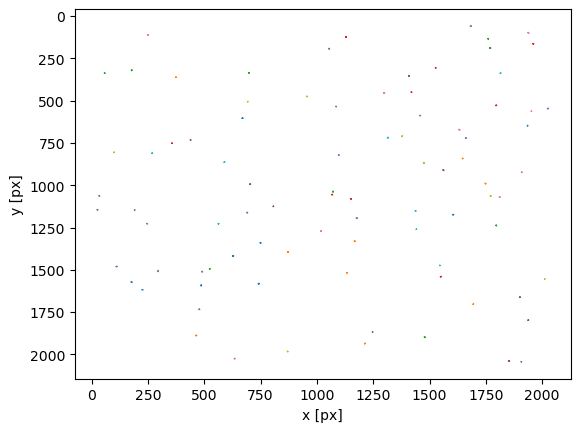

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [567]:
tp.plot_traj(traj=df_adjusted)

In [568]:
df_adjusted.drop(['adjusted_x', 'adjusted_y', 'adjusted_dx', 'adjusted_dy'], axis=1, inplace=True)

In [569]:
# Calculer les différences de position
df_adjusted['dx'] = df_adjusted.groupby('particle')['x'].diff().fillna(0)
df_adjusted['dy'] = df_adjusted.groupby('particle')['y'].diff().fillna(0)

# Calculer la distance parcourue à chaque pas de temps
df_adjusted['distance'] = (df_adjusted['dx']**2 + df_adjusted['dy']**2).pow(0.5)

# Calculer la vitesse pour chaque pas de temps
df_adjusted['vitesse'] = df_adjusted['distance'] / DELTA_T

# Calculer la vitesse moyenne pour chaque particule
vitesse_moyenne = df_adjusted.groupby('particle')['vitesse'].mean()

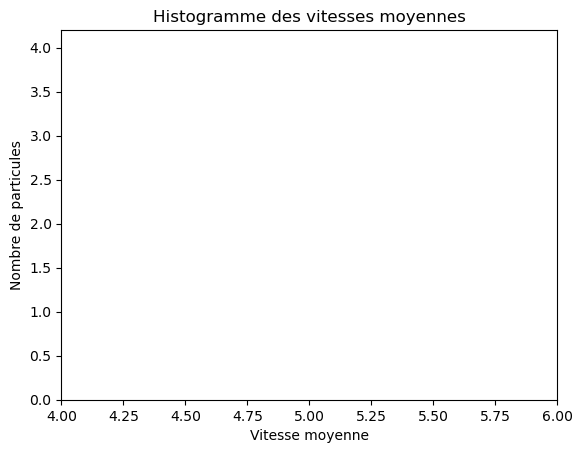

In [570]:
# Tracer l'histogramme des vitesses moyennes
plt.hist(vitesse_moyenne, bins=100)

# Ajuster les limites de l'axe x pour correspondre à la plage de l'histogramme
plt.xlim(4, 6)

# Ajouter des titres et des étiquettes
plt.title('Histogramme des vitesses moyennes')
plt.xlabel('Vitesse moyenne')
plt.ylabel('Nombre de particules')

# Afficher l'histogramme
plt.show()

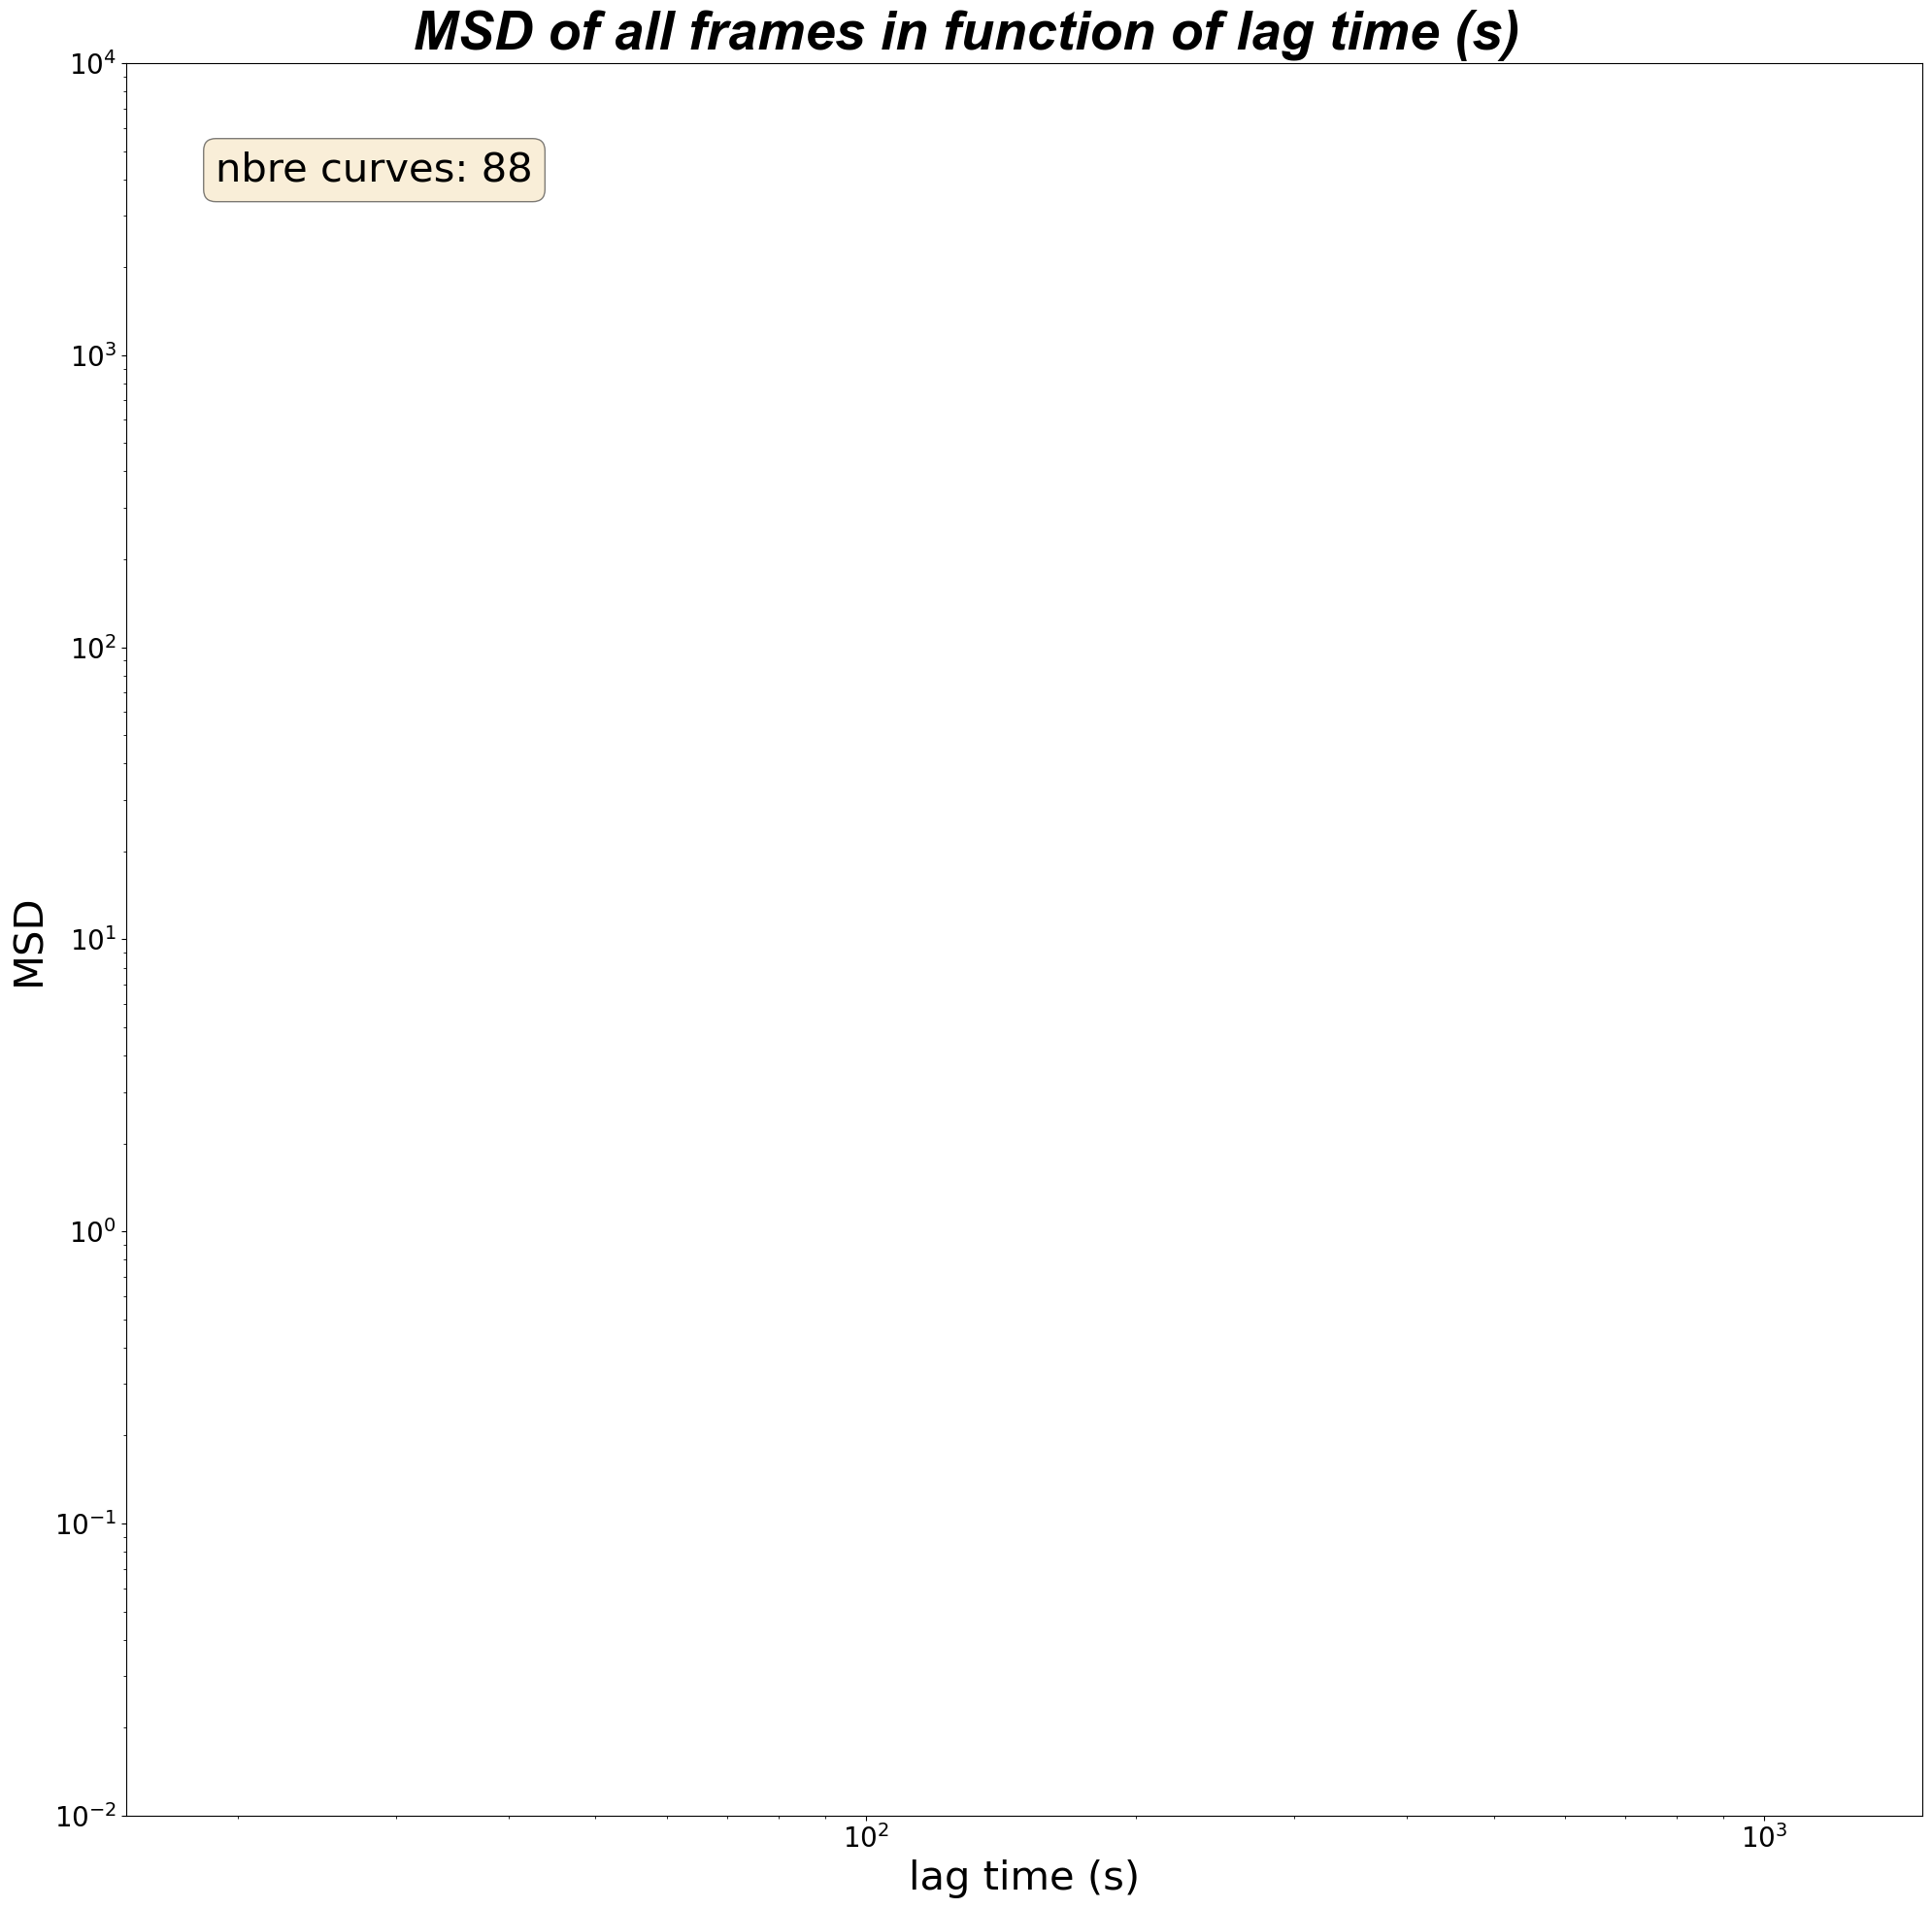

In [571]:
def plot_msd(msd, fps, name="MSD of all frames in function of lag time (s)",
             color_plot: str = 'red', save=False, pathway_saving=None,
             alpha=0.05, linewidth=0.01, img_type='jpg'):
    """
    Plot the mean square displacement (MSD) for a specific need.

    Parameters
    ----------
    msd : DataFrame
        DataFrame containing the MSD values.
    fps : float
        Number of frames per second.
    name : str, optional
        Title of the plot. Default is "MSD of all frames in function of lag time (s)".
    save : bool, optional
        Whether to save the plot or not. Default is False.
    pathway_saving : str, optional
        Absolute path to save the plot. Default is None.

    Returns
    -------
    None.

    """
    # Get the number of curves from the number of columns in the MSD DataFrame
    nbr_curves = len(msd.columns)

    # # Set the index
    # msd = msd.set_index("lag time [s]")

    # Create a new figure and axis object
    fig, axis = plt.subplots(figsize=(20, 20))

    # Plot the MSD data on the axis object
    axis.plot(msd, alpha=alpha, linewidth=linewidth, color=color_plot)

    # Set the limits of the x-axis and y-axis
    axis.set_xlim([1 / fps, 100 / fps])
    axis.set_ylim(0.01, 10000)

    # Set the x-axis and y-axis to be on a log scale
    axis.set(xscale="log", yscale="log")

    # Set the x-axis label
    axis.set_xlabel("lag time (s)", fontsize=30)

    # Set the x-axis label
    axis.set_ylabel("MSD", fontsize=30)

    # Add a text box to the plot with the number of curves
    textstr = f"nbre curves: {nbr_curves}"
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    axis.text(0.05, 0.95, textstr, transform=axis.transAxes, fontsize=30,
              verticalalignment="top", bbox=props)

    axis.tick_params(axis='both', which='major', labelsize=20)

    # Set the title of the plot
    fig.suptitle(name, fontsize=40, fontweight="bold", fontstyle='italic', fontname="Arial")

    # Adjust the spacing of the plot
    fig.tight_layout()

    # Save the plot if the "save" parameter is True
    if save:
        fig.savefig(f"{pathway_saving}{name}." + img_type, format=img_type)


IMSD = tp.imsd(df_adjusted, mpp = 0.637, fps = 1/15)


plot_msd(IMSD, fps=1/15, name="MSD of all frames in function of lag time (s)",
             color_plot = 'red', save=False, pathway_saving=None,
             alpha=0.5, linewidth=0.3, img_type='jpg')

# negative slope 0


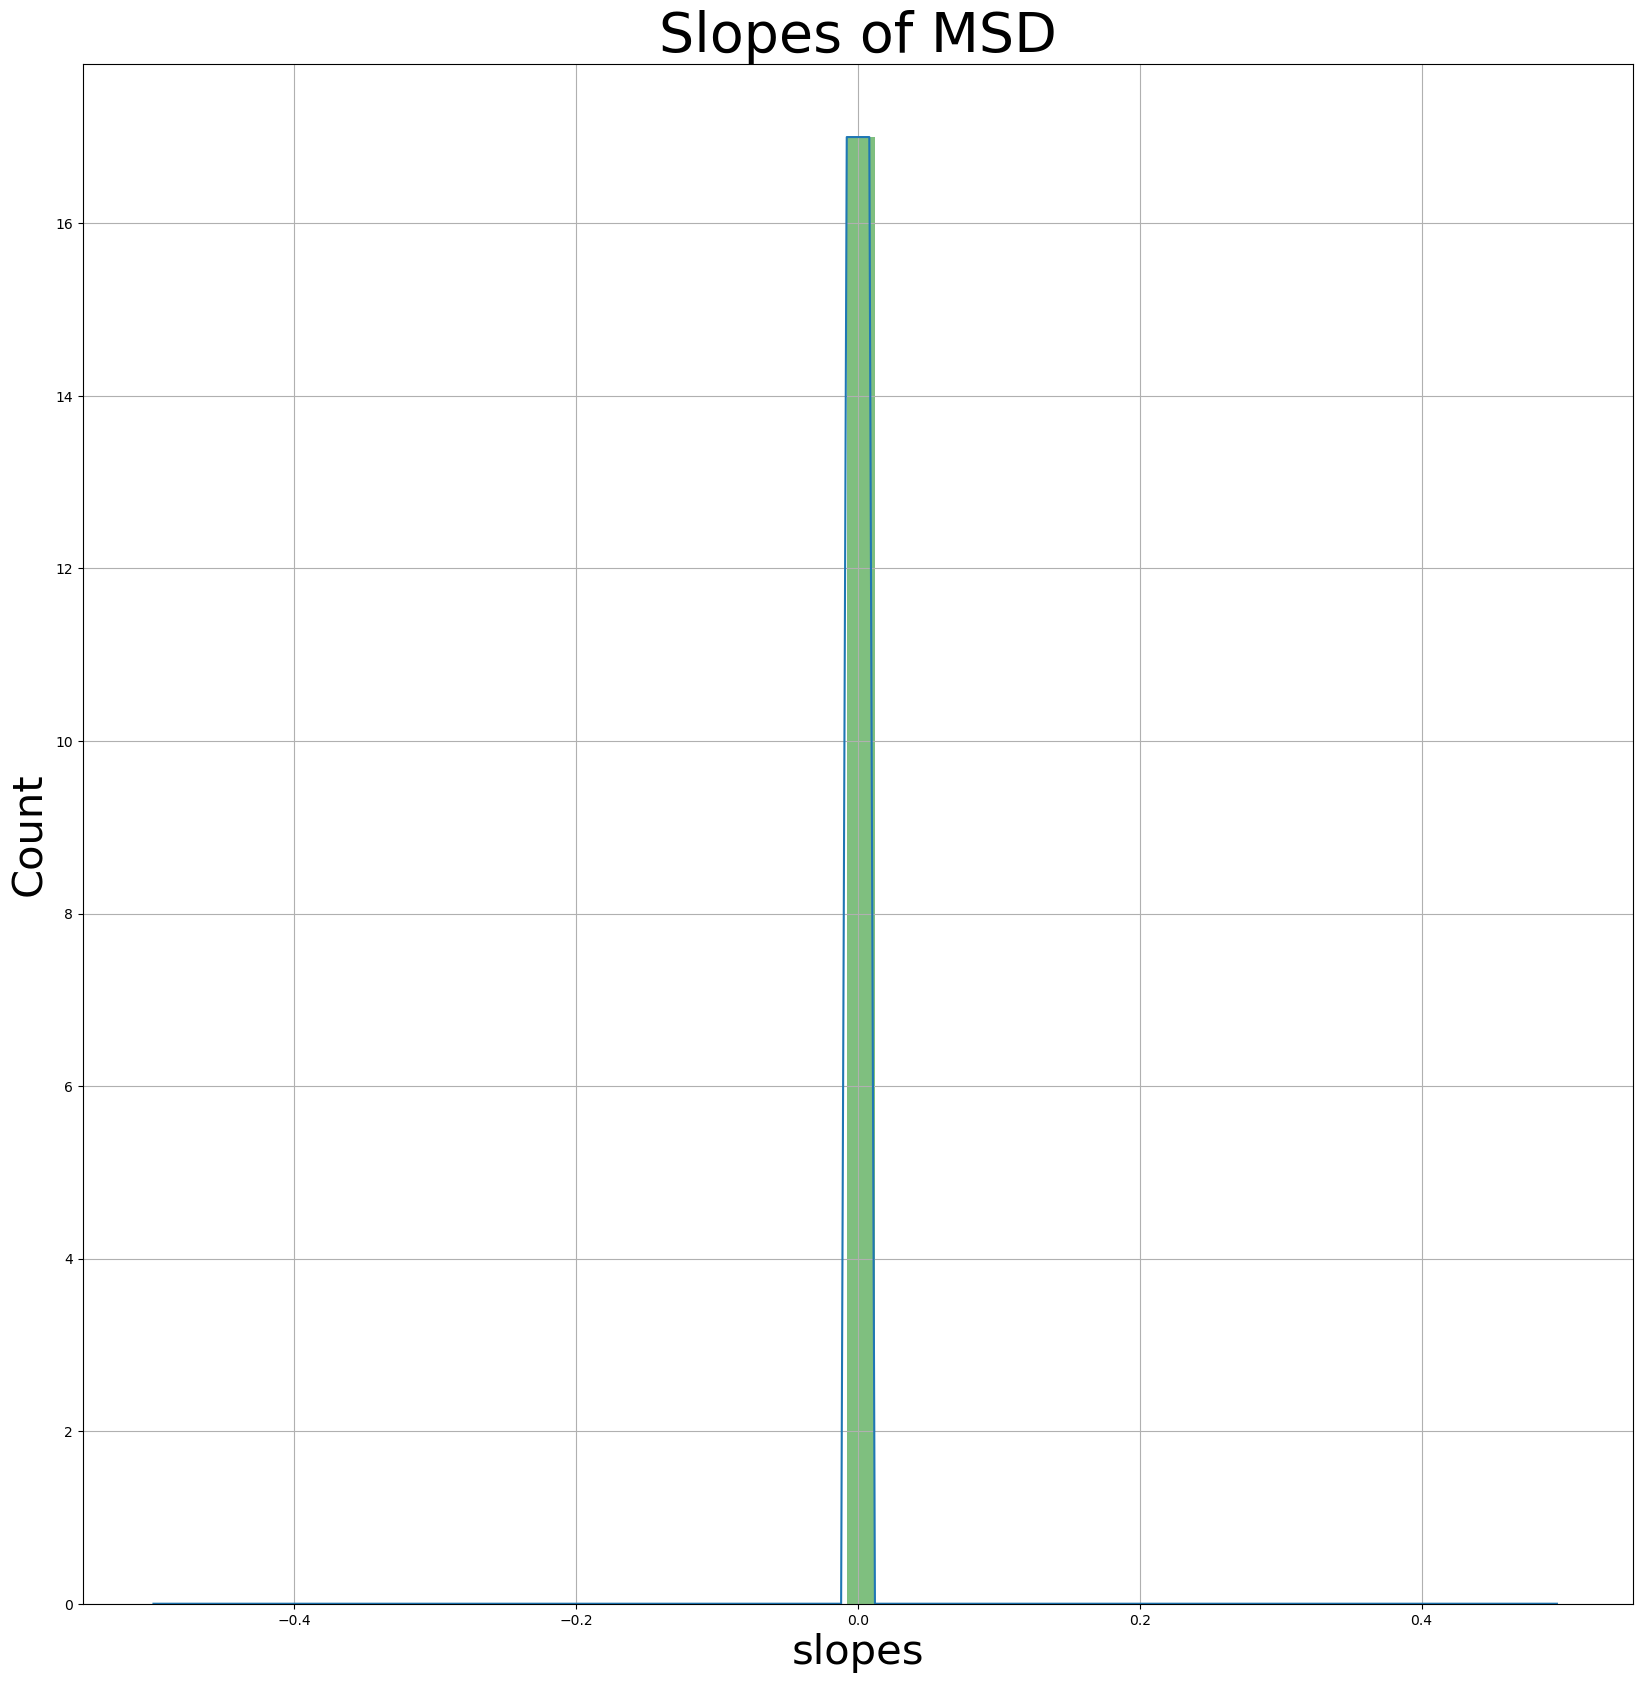

/Users/souchaud/Desktop/Dictyostelium/Motility/simulations/particle_model/functions_analyze.py:2689: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  Ax[0].set_yscale("log")


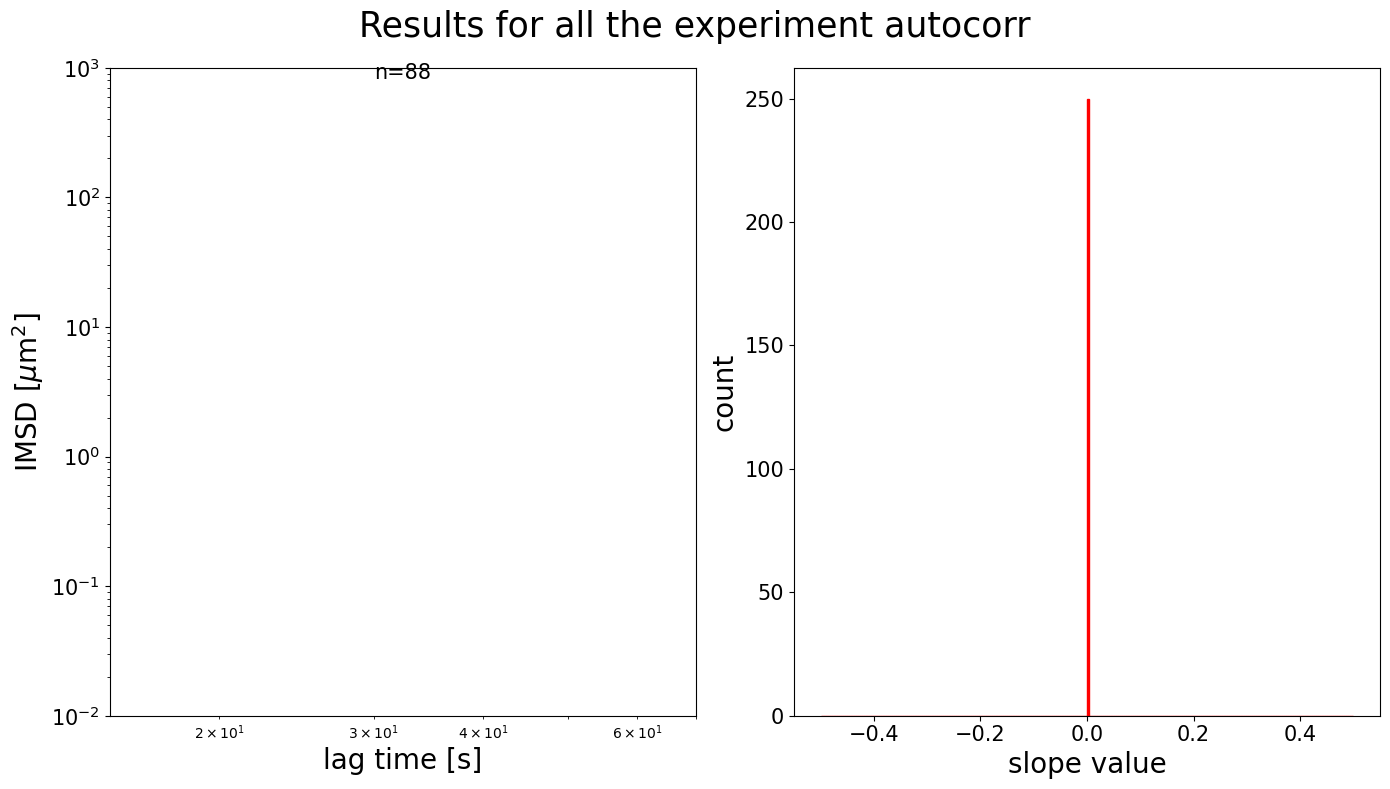

In [572]:
# %% [traj clustering with fit and defining a cutoff]
LAG_TIME_FIT = 5
# plot parameters
IMG_TYPE = 'jpg'
ALPHA = 0.5
LINEWIDTH = 0.1
COLOR_SUP = 'blue'
COLOR_INF = 'red'
color_sup_inf = (COLOR_SUP, COLOR_INF)
# Compute et plot the director factor of the imsd

COEF_INF, COEF_SUP, PART_COEF_INF, PART_COEF_SUP, CUTOFF =\
   lib.traj_clustering_with_fit_cutoff(df_adjusted, imsd=IMSD, hist=True,
                                        lag_time_fit=LAG_TIME_FIT,
                                        micronperpixel=0.637,
                                        fps=1/15, binsize=250,
                                        peak_height=50, peak_width=1,
                                        save=False, pathway_fig=None,
                                        name='all the experiment autocorr', img_type="jpg",
                                        plot=True, color_sup_inf=color_sup_inf,
                                        cutoff_default=1.4
                                        )

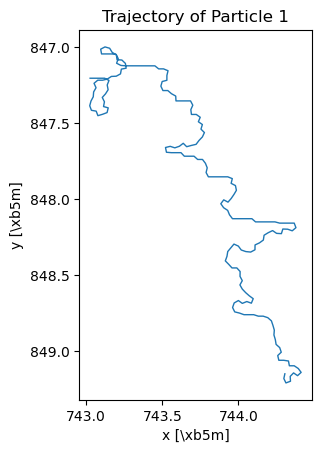

In [573]:
# Supposons que df_adjusted est votre DataFrame après ajustements avec 'particle', 'x', et 'y'
particle_df = df_adjusted[df_adjusted['particle'] == 1]
fig, ax = plt.subplots()
tp.plot_traj(particle_df, mpp=0.637, fps=15/60, ax=ax)
# Rendre les échelles des axes x et y égales
ax.set_aspect('equal', 'box')
# Ajouter un titre
ax.set_title('Trajectory of Particle 1')
plt.show()


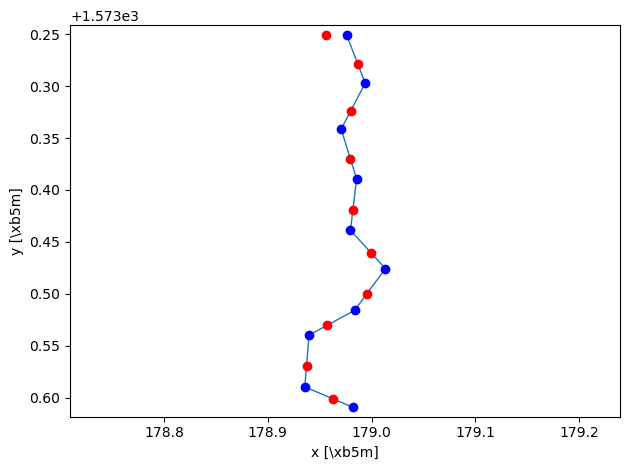

In [574]:
# Filtrer le DataFrame pour une particule spécifique
particle_df = df_adjusted[df_adjusted['particle'] == 0].iloc[0:10]
particle_df['normdxdy'] = (particle_df['dir_x']**2 + particle_df['dir_y']**2)**0.5
fig, ax = plt.subplots()
# Tracer la trajectoire de la particule
tp.plot_traj(particle_df, mpp=1, fps=15/60, ax = ax)
# Obtenir l'axe actuel
ax = plt.gca()

# Pour chaque point de la trajectoire, ajouter un point représentant la direction
for index, row in particle_df.iterrows():
    # Le point de départ du point (position de la particule)
    
    # Calculer la position du point de direction (en ajoutant un facteur d'échelle aux composantes de direction si nécessaire)
    dir_x = row['x'] + row['dir_x']*0.02   # Facteur d'échelle pour déterminer la position du point de direction
    dir_y = row['y'] + row['dir_y']*0.02  # Facteur d'échelle pour déterminer la position du point de direction
    ax.plot(row['x'], row['y'], 'bo')  # 'ro' crée un point rond rouge
    # Ajouter le point de direction au graphique
    ax.plot(dir_x, dir_y, 'ro')  # 'ro' crée un point rond rouge

# Afficher le graphique
# Assurer les mêmes échelles en x et y
ax.axis('equal')
plt.tight_layout()
plt.show()


In [575]:

#     # return np.degrees(angle_change)  # Convert angle to degrees
#     # Calculate the angle difference
#     angle_change = np.arccos(dx1*dx2+dy1*dy2)
#     # Normalize the angle to be between -pi and pi
#     # angle_change = np.arctan2(np.sin(angle_change), np.cos(angle_change))

In [576]:
# Fonction pour calculer l'angle en degrés entre deux vecteurs de direction successifs
def angle_between_directions(row):
    # Extract direction components
    dx1, dy1 = row['dir_x'], row['dir_y']
    dx2, dy2 = row['dir_x_next'], row['dir_y_next']
    
    # Calculate initial and final angles using arctan2 for each direction vector
    angle_initial = np.arctan2(dy1, dx1)
    angle_final = np.arctan2(dy2, dx2)
    
    # Calculate the angle difference
    angle_change = angle_final - angle_initial
    
    # Normalize the angle to be between -pi and pi
    angle_change = np.arctan2(np.sin(angle_change), np.cos(angle_change))
    # if angle_change > 1.49 and angle_change < 1.51:
    #     print(row)
    return angle_change
df = df_adjusted.copy()
# Assurez-vous que votre DataFrame est trié par particule et par frame
df.sort_values(by=['particle', 'frame'], inplace=True)

# Décaler les directions pour obtenir le vecteur direction au temps t+1 pour chaque particule
df['dir_x_next'] = df.groupby('particle')['dir_x'].shift(-1)
df['dir_y_next'] = df.groupby('particle')['dir_y'].shift(-1)

# Appliquer la fonction pour calculer l'angle entre les directions successives
df['angle_change'] = df.apply(angle_between_directions, axis=1)

# Optionnel : Supprimer les lignes où la direction suivante est NaN, ce qui se produit pour la dernière observation de chaque particule
df.dropna(subset=['dir_x_next', 'dir_y_next'], inplace=True)

# Afficher le résultat
# print(df[['frame', 'particle', 'dir_x', 'dir_y', 'dir_x_next', 'dir_y_next', 'angle_change']])


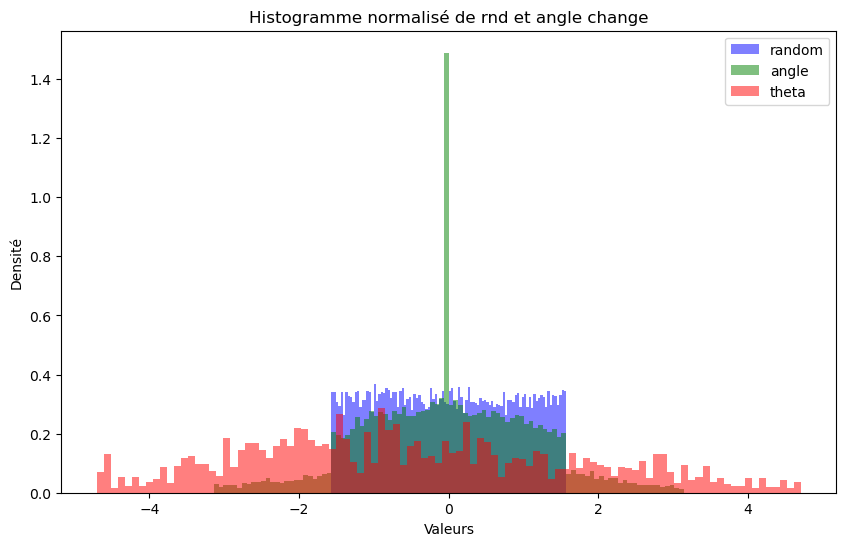

In [585]:
# Créer une nouvelle figure
plt.figure(figsize=(10, 6))

# Tracer l'histogramme pour 'rnd' (normalisé)
plt.hist(df['rnd'], bins=100, alpha=0.5, color='blue', label='random', density=True)

# Tracer l'histogramme pour 'angle_change' (normalisé)
plt.hist(df['angle_change'], bins=100, alpha=0.5, color='green', label='angle', density=True)

plt.hist(df['theta'], bins=100, alpha=0.5, color='red', label='theta', density=True)

# Ajouter une légende
plt.legend()

# Ajouter des labels et un titre
plt.xlabel('Valeurs')
plt.ylabel('Densité')
plt.title('Histogramme normalisé de rnd et angle change')

# Afficher la figure
plt.show()


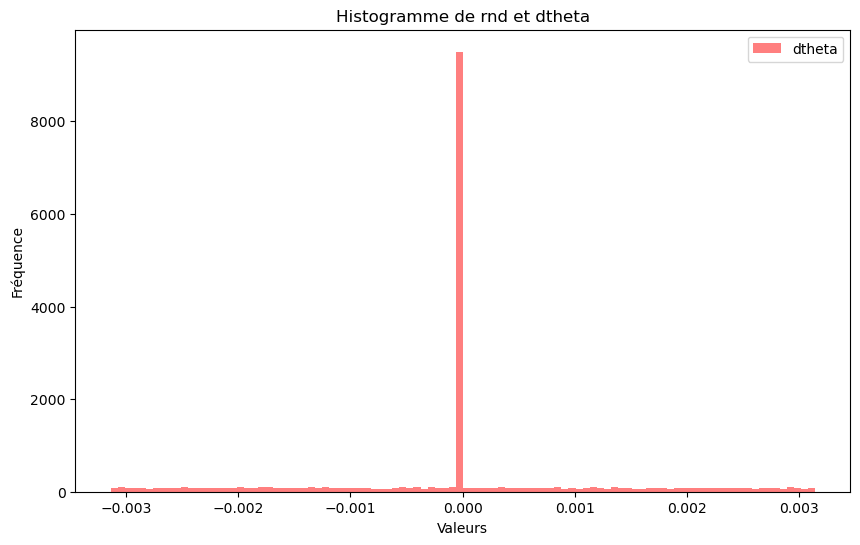

In [578]:
# Créer une nouvelle figure
plt.figure(figsize=(10, 6))

# Tracer l'histogramme pour 'dtheta'
plt.hist(df['dtheta'] , bins=100, alpha=0.5, color='red', label='dtheta')

# Ajouter une légende
plt.legend()

# Ajouter des labels et un titre
plt.xlabel('Valeurs')
plt.ylabel('Fréquence')
plt.title('Histogramme de rnd et dtheta')

# Afficher la figure
plt.show()

In [579]:
def angle_between_directions_dxdy(row):
    # Extract direction components
    dx1, dy1 = row['dx_normalized'], row['dy_normalized']
    dx2, dy2 = row['dx_next_normalized'], row['dy_next_normalized']
    
    
    # Calculate initial and final angles using arctan2 for each direction vector
    angle_initial = np.arctan2(dy1, dx1)
    angle_final = np.arctan2(dy2, dx2)
    
    # Calculate the angle difference
    angle_change = angle_final - angle_initial
    
    # Normalize the angle to be between -pi and pi
    angle_change = np.arctan2(np.sin(angle_change), np.cos(angle_change))
    return angle_change
# Calculer la norme de chaque vecteur
norms = np.sqrt(df['dx']**2 + df['dy']**2)

# Normaliser les composantes dx et dy
df['dx_normalized'] =  df['dx'] / norms
df['dy_normalized'] = df['dy'] / norms
df['dx_next_normalized'] = df.groupby('particle')['dx_normalized'].shift(-1)
df['dy_next_normalized'] = df.groupby('particle')['dy_normalized'].shift(-1)

df['angle_dxdy'] = df.apply(angle_between_directions_dxdy, axis=1)

In [580]:
def angle_between_directions(row):
    # Extract direction components
    dx1, dy1 = row['dir_x'], row['dir_y']
    dx2, dy2 = row['dir_x_next'], row['dir_y_next']
    
    
    # Calculate initial and final angles using arctan2 for each direction vector
    angle_initial = np.arctan2(dy1, dx1)
    angle_final = np.arctan2(dy2, dx2)
    
    # Calculate the angle difference
    angle_change = angle_final - angle_initial
    
    # Normalize the angle to be between -pi and pi
    angle_change = np.arctan2(np.sin(angle_change), np.cos(angle_change))
    if angle_change > 1.49 and angle_change < 1.51:
        print(row)
    return angle_change



In [581]:
# import matplotlib.pyplot as plt
# import trackpy as tp
# # Filtrer le DataFrame pour une particule spécifique
# df['normdxdy'] = (df['dir_x']**2 + titi['dir_y']**2)**0.5
# fig, ax = plt.subplots()
# # Tracer la trajectoire de la particule
# tp.plot_traj(titi, mpp=1, fps=15/60, ax = ax)
# # Obtenir l'axe actuel
# ax = plt.gca()

# # Pour chaque point de la trajectoire, ajouter un point représentant la direction
# for index, row in particle_df.iterrows():
#     # Le point de départ du point (position de la particule)
    
#     # Calculer la position du point de direction (en ajoutant un facteur d'échelle aux composantes de direction si nécessaire)
#     dir_x = row['x'] + row['dir_x']*0.02   # Facteur d'échelle pour déterminer la position du point de direction
#     dir_y = row['y'] + row['dir_y']*0.02  # Facteur d'échelle pour déterminer la position du point de direction
#     ax.plot(row['x'], row['y'], 'bo')  # 'ro' crée un point rond rouge
#     # Ajouter le point de direction au graphique
#     ax.plot(dir_x, dir_y, 'ro')  # 'ro' crée un point rond rouge

# # Afficher le graphique
# # Assurer les mêmes échelles en x et y
# ax.axis('equal')
# plt.tight_layout()
# plt.show()

numpy.float64

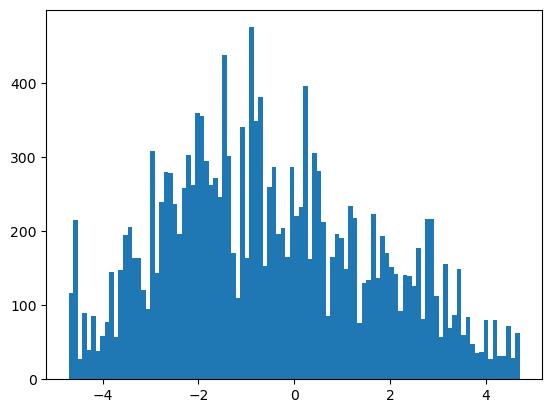

In [582]:
plt.hist(df['theta'], bins= 100)
type(df['theta'].iloc[0])

In [583]:
df['theta'].max()

4.71006441116333